In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import struct
from astropy.time import Time
%matplotlib inline

In [2]:
#Pulsar header
pulsar_data = open("AST326_ARO_B0329+54.dat", "rb")
header_packed = pulsar_data.read(48)
header_unpacked = struct.unpack('=iiiidiiiId', header_packed)

slice_length = header_unpacked[0]
header_length = header_unpacked[1]
number_samples = header_unpacked[2]
data_type = header_unpacked[3]
cadence_raw = header_unpacked[4]
number_freqs = header_unpacked[5]
number_elems = header_unpacked[6]
spec_sum = header_unpacked[7]
handshake_index = header_unpacked[8]
handshake_utc = header_unpacked[9]

#Pulsar frequencies
header_info = pulsar_data.read(number_freqs*4*2)
freq_list = np.frombuffer(header_info[:number_freqs*4*2], dtype=np.float32)
freq_list = freq_list.reshape(-1,2)
freqs = freq_list.mean(axis=1)

#Import the data
data_list = [] #Create empty list for 10 000 points to be appended to 
for i in np.arange(10000): #Iterate through 10 000 points
    data_header = np.frombuffer(pulsar_data.read(header_length), dtype=np.float32) #Bring in header data
    index, az, alt = struct.unpack('Iff', data_header) #Bring in index, azimuth, altitude data
    data = np.frombuffer(pulsar_data.read(slice_length-header_length),dtype=np.float32) #Bring in 10 000 points of data
    data_list.append(data) #Append data to list
data_array = np.array(data_list) #Turn list into array

#Define time data
timestep = cadence_raw*spec_sum
t = timestep*np.arange(data_array.shape[0]) 

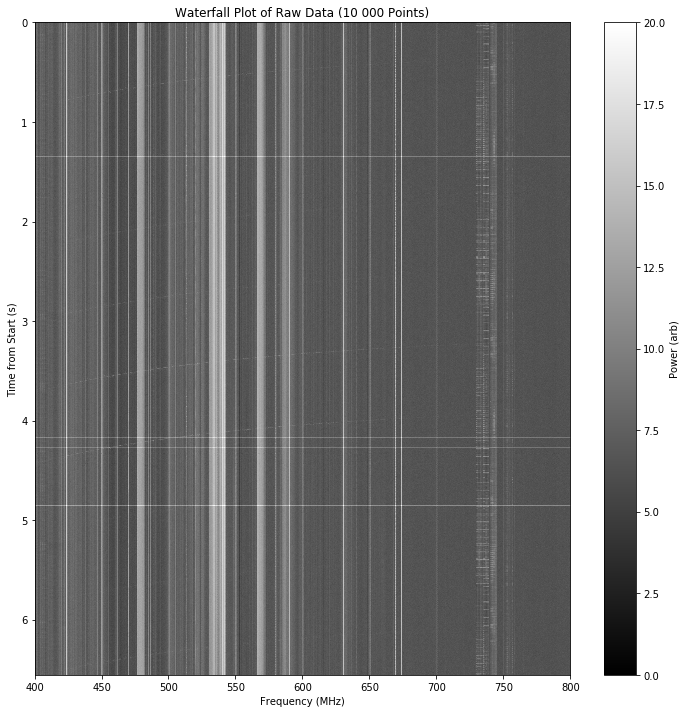

In [3]:
#Waterfall plot of raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(data_array),aspect="auto", extent=[400,800,np.amax(t), np.amin(t)], vmax=20, vmin=0, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of Raw Data (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_raw_10000.pdf')

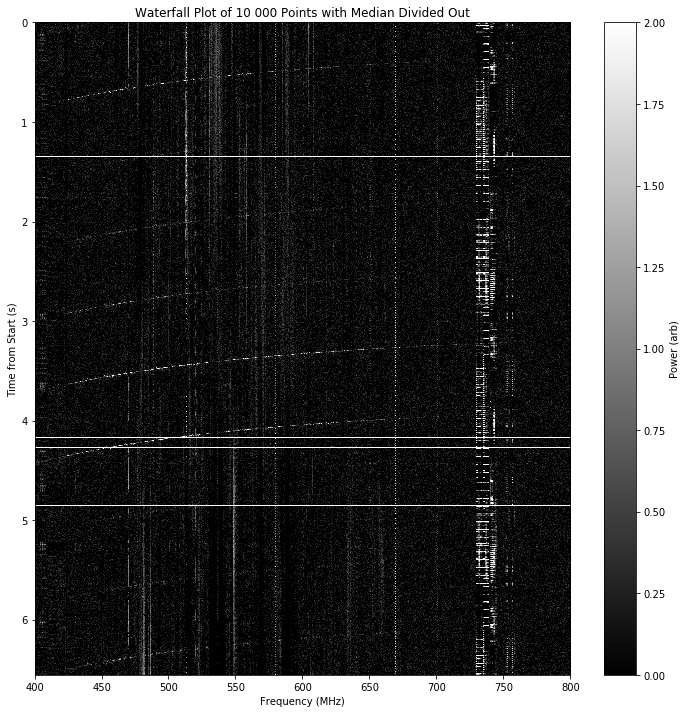

In [4]:
#Divide out median to reduce noise
median_RFI = np.median(data_array, axis=0) #Calculate median
RFI_less = data_array/median_RFI #Divide by median

#Plot data with median divided out
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(RFI_less), extent=[400,800,np.amax(t), np.amin(t)], aspect='auto', vmax=2, vmin=0, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Time from Start (s)')
plt.title('Waterfall Plot of 10 000 Points with Median Divided Out')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_clean_10000.pdf')

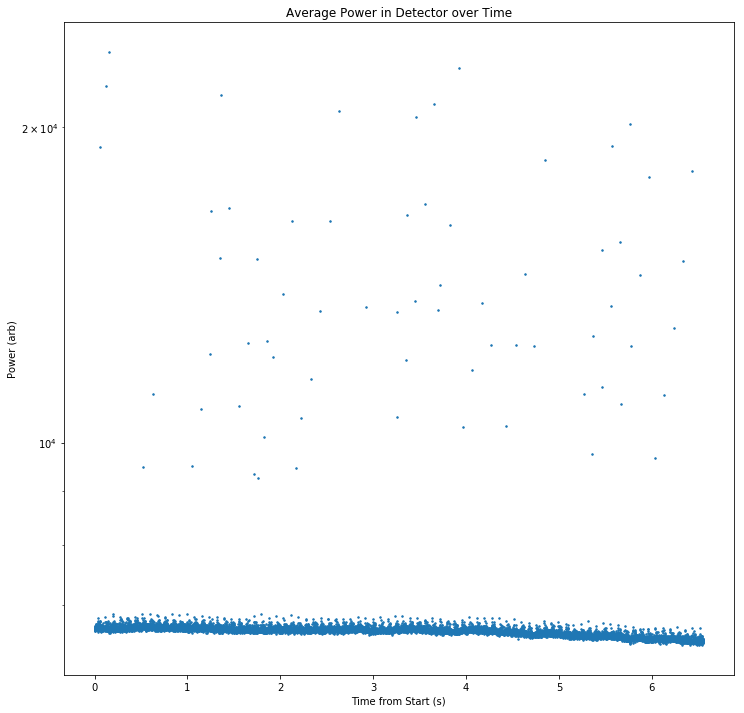

In [5]:
#Cut out RFI
data_sum = np.sum(data_array, axis=1) #Sum data over the frequencies

#Plot this to see where the RFI is
plt.figure(figsize=(12,12))
plt.plot(t, data_sum, ls='', marker = 'o', markersize = 1.5)
plt.semilogy()
plt.xlabel('Time from Start (s)')
plt.ylabel('Power (arb)')
plt.title('Average Power in Detector over Time')
plt.savefig('RFI_find_10000.pdf')

#Define where the RFI is
large_values = np.where(data_sum > 7820)
period = 0.714519699726 #period
sample_period = period/timestep #how many samples in a period, dt is time per sample 
number_pulses_exp = int(10000/sample_period) #how many pulses you expect to have (can count these in plot, should be about 9)

In [6]:
#Fold the data
freq_number = 1024
pixel_bins = 500 #Define bins for resolution
folded_pulses = np.zeros((pixel_bins, freq_number)) #Create array for folded pulses
pulse_in_phase = np.zeros((pixel_bins, freq_number)) #Create array for number of pulses folding over

#Cut RFI out of the data
RFI_noise = large_values[0].tolist() 
RFI_noise.append([0])
for i in np.arange(data_array.shape[0]):
    if i == RFI_noise[0]: 
        RFI_noise.pop(0) #Pop out RFI
        continue #Continue through array until reach next RFI point
    #Define phase of pulses
    phase = np.int(pixel_bins*np.modf(i*timestep/period)[0])
    folded_pulses[phase,:] += data_array[i,:] #Summing over the power to fold
    pulse_in_phase[phase,:] += 1 #How many pulses summing over 

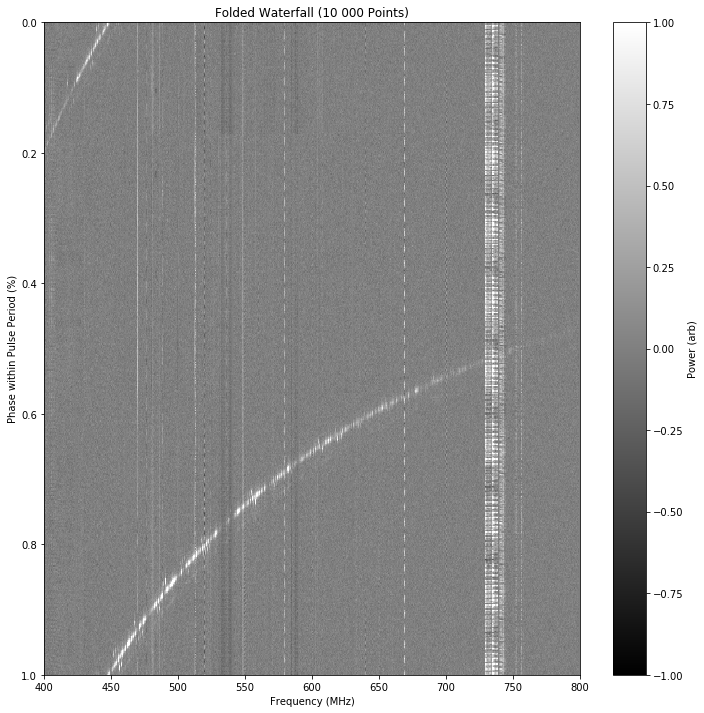

In [7]:
#Check the fold
fold_avg = folded_pulses/pulse_in_phase 
folded_data = fold_avg/median_RFI #Divide out median to reduce noise

#Plot folded data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(folded_data), extent=[400,800,1, 0], aspect='auto', vmax=1, vmin=-1, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (%)')
plt.title('Folded Waterfall (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_folded_10000.pdf')

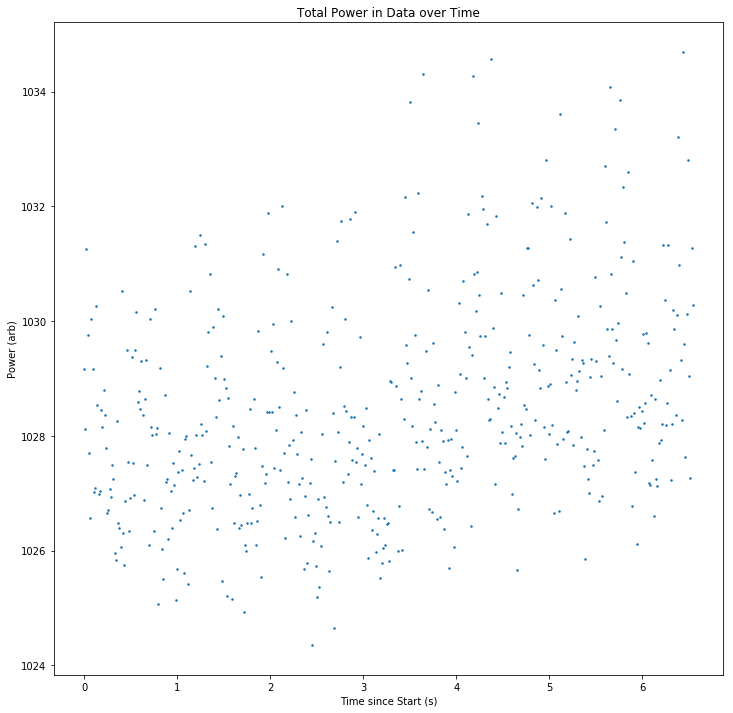

In [8]:
#Clean up fold
fold_sum = np.sum(folded_data, axis=1) #Sum over the frequency axis

#Plot to see where the RFI is (there isn't really any)
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t), np.amax(t), (np.amax(t) - np.amin(t))/500), fold_sum, ls='', marker='o', markersize=1.5)
plt.title('Total Power in Data over Time')
plt.xlabel('Time since Start (s)')
plt.ylabel('Power (arb)')
plt.savefig('RFI2_10000.pdf')

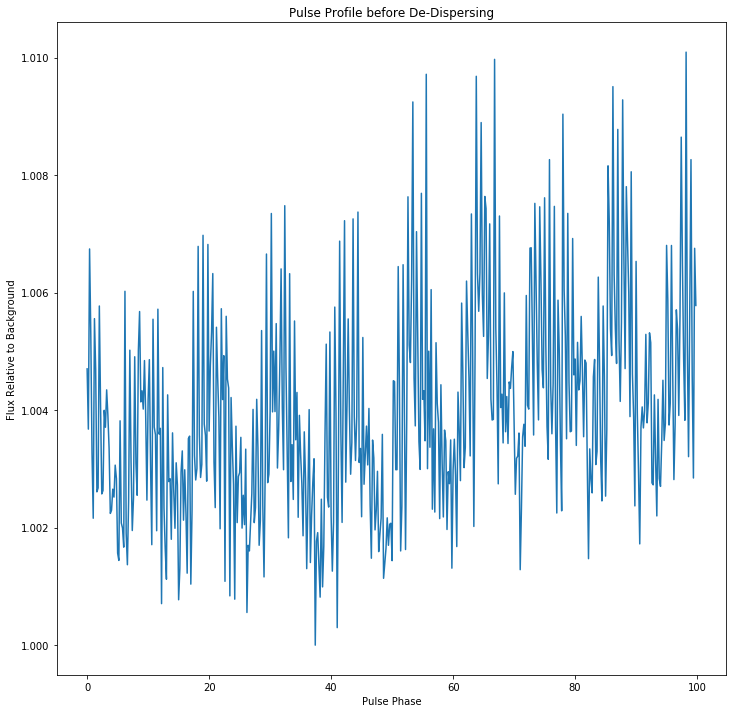

In [9]:
#Calculate profile before de-dispersing
profile_dispersed = np.sum(folded_data, axis=1)
#Normalize
normal_profile_dispersed = profile_dispersed/np.min(profile_dispersed)

#Plot profile before de-dispersing
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile_dispersed)
plt.title('Pulse Profile before De-Dispersing')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('pulse_profile_dispersed_10000.pdf')

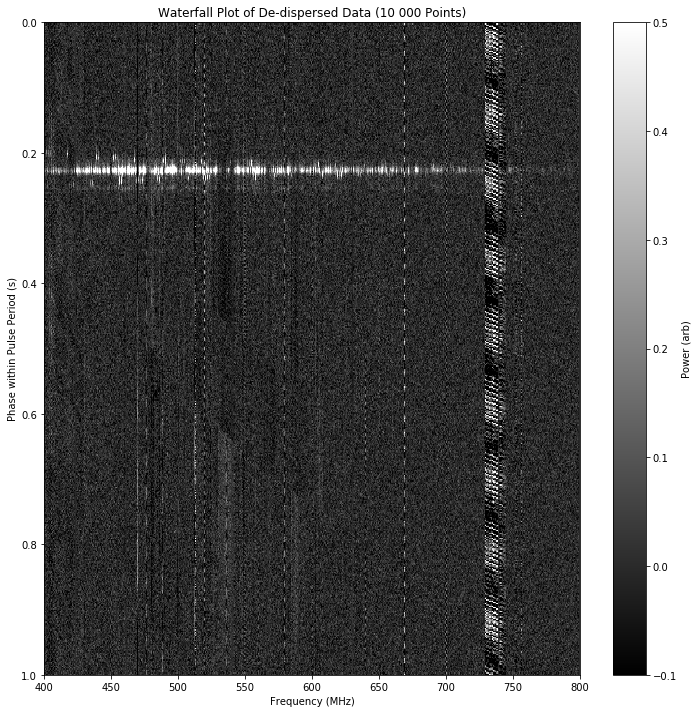

In [13]:
#De-disperse
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate dispersion 
dm_array = np.zeros((500,1024)) #Create array to put de-dispersed data into
for i in np.arange(freq_number): #Iterate through number of frequencies
    dm_array[:,i] = np.roll(folded_data[:,i], -int(dispersion[i]/period*pixel_bins)) #Roll over the period to de-disperse

#Divide by median to reduce noise
dedispersed_data = dm_array/np.median(dm_array, axis=0)

plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_data), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', \
           vmin = -.1, vmax = .5, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_de_dispersed_10000.pdf')

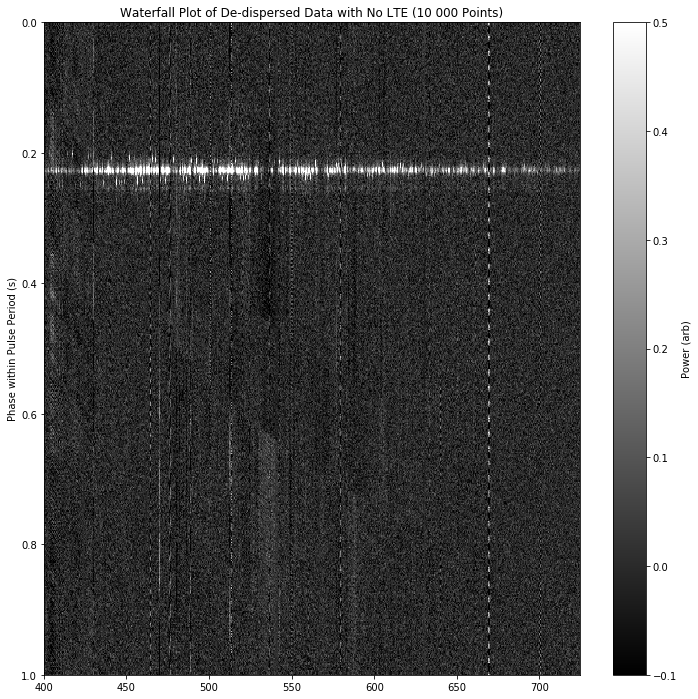

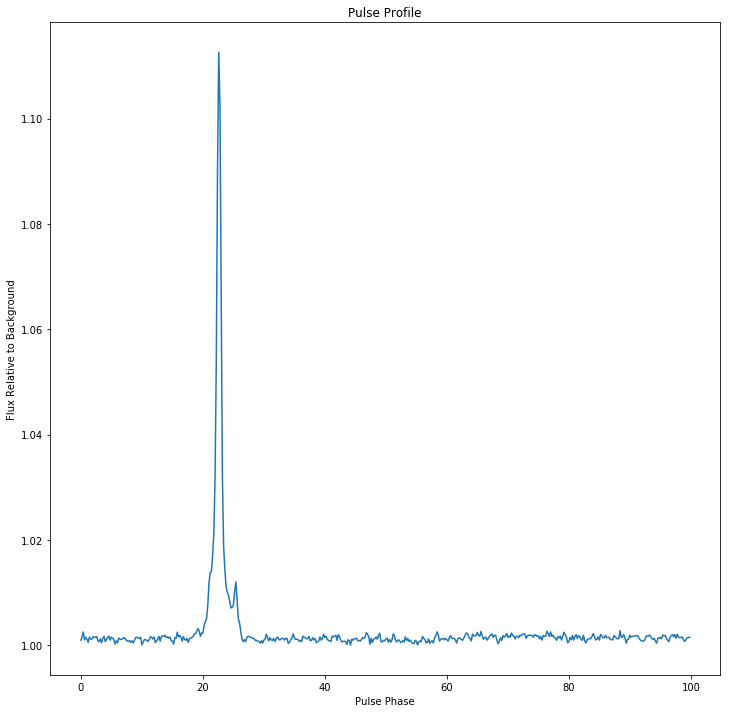

In [12]:
#Cut out LTE band
LTE_less = []
temp_list = []
for i in np.arange(0,500):
    temp_list = list(dedispersed_data[i][0:830])
    LTE_less.extend(temp_list)
LTE_less_array = np.array(LTE_less)
LTE_reshaped = LTE_less_array.reshape(500,830)

#Plot LTE-less data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, \
           vmax = .5, cmap='gray')
plt.title('De-dispersed Data with LTE Band Excised')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of De-dispersed Data with No LTE (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('waterfall_dedispersed_noLTE_10000.pdf')

#Sum over frequency axis to create pulse profile
profile = np.sum(LTE_reshaped, axis=1)
#Normalize
normal_profile = profile/np.min(profile)

#Plot normal pulse profile
plt.figure(figsize=(12,12))
plt.plot(np.arange(0,100,100/500),normal_profile)
plt.title('Pulse Profile')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('pulse_profile_10000.pdf')

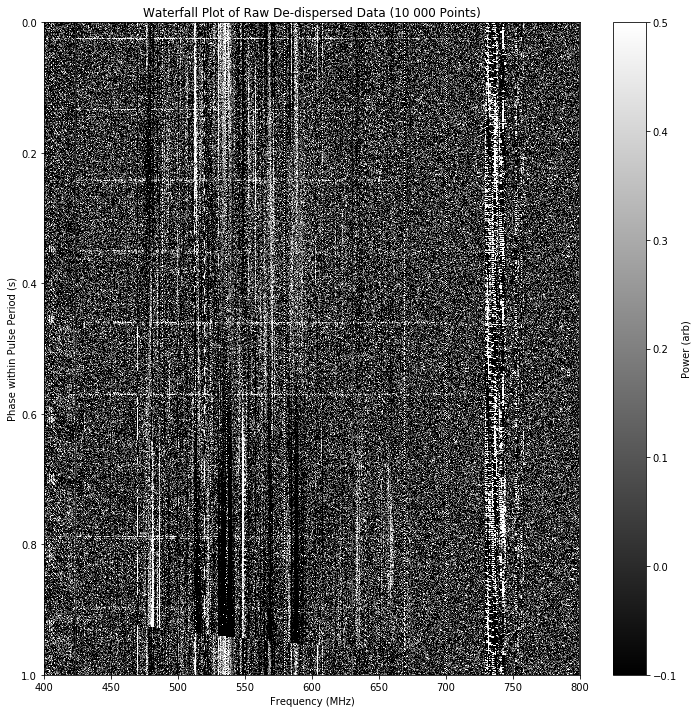

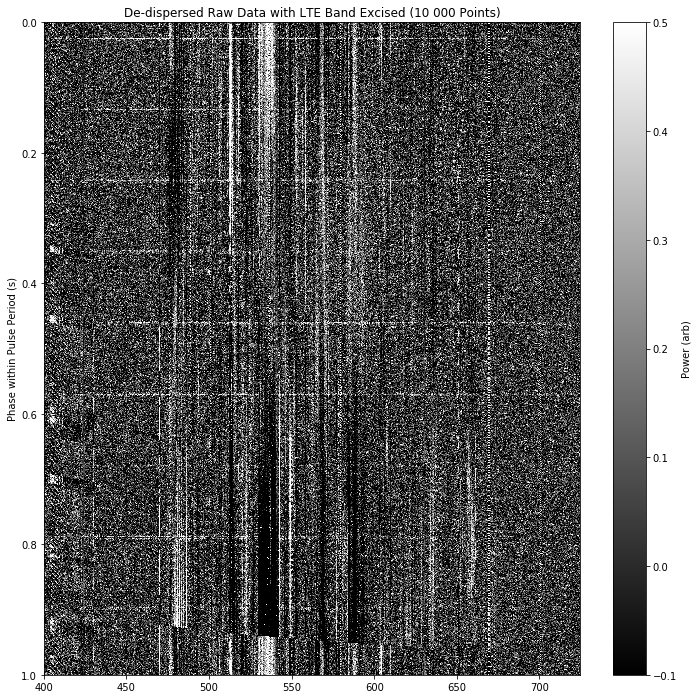

In [19]:
#De-disperse raw dataset 
k = 4.15e-3 #Dispersion measure time prefactor
dm = 26.7641 #Dispersion measure
dispersion = (k*dm*(freqs/1000)**-2) #Calculate dispersion
dm_array_raw = np.zeros((10000,1024)) #Create array for de-dispersed data
for i in np.arange(freq_number): #Iterate through number of frequencies
    dm_array_raw[:,i] = np.roll(RFI_less[:,i], -int(dispersion[i]/timestep)) #Roll in time to de-disperse

#Divide by the median to reduce noise
dedispersed_raw = dm_array_raw/np.median(dm_array_raw, axis=0)

#Plot the de-dispersed raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(dedispersed_raw), extent = [np.amin(freqs), np.amax(freqs), 1, 0], aspect = 'auto', \
           vmin = -.1, vmax = .5, cmap='gray')
plt.xlabel('Frequency (MHz)')
plt.ylabel('Phase within Pulse Period (s)')
plt.title('Waterfall Plot of Raw De-dispersed Data (10 000 Points)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('raw_dedispersed_10000.pdf')

#Remove LTE as above
LTE_less_raw = []
temp_list_raw = []
for i in np.arange(0,10000):
    temp_list_raw = list(dedispersed_raw[i][0:830])
    LTE_less_raw.extend(temp_list_raw)
LTE_raw_array = np.array(LTE_less_raw)
LTE_raw_reshaped = LTE_raw_array.reshape(10000,830)

#Plot LTE-less de-dispersed raw data
plt.figure(figsize=(12,12))
plt.imshow(10*np.log10(LTE_raw_reshaped), extent = [np.amin(freqs), 724.41406, 1, 0], aspect = 'auto', vmin = -.1, \
           vmax = .5, cmap='gray')
plt.title('De-dispersed Raw Data with LTE Band Excised (10 000 Points)')
plt.ylabel('Phase within Pulse Period (s)')
plt.colorbar().set_label('Power (arb)', rotation=90)
plt.savefig('dedispersed_raw_noLTE_10000.pdf')

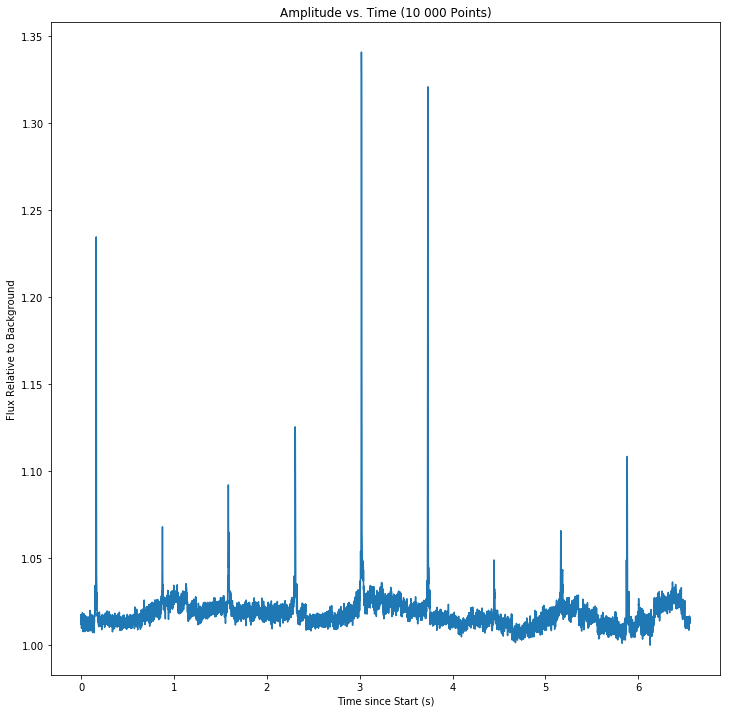

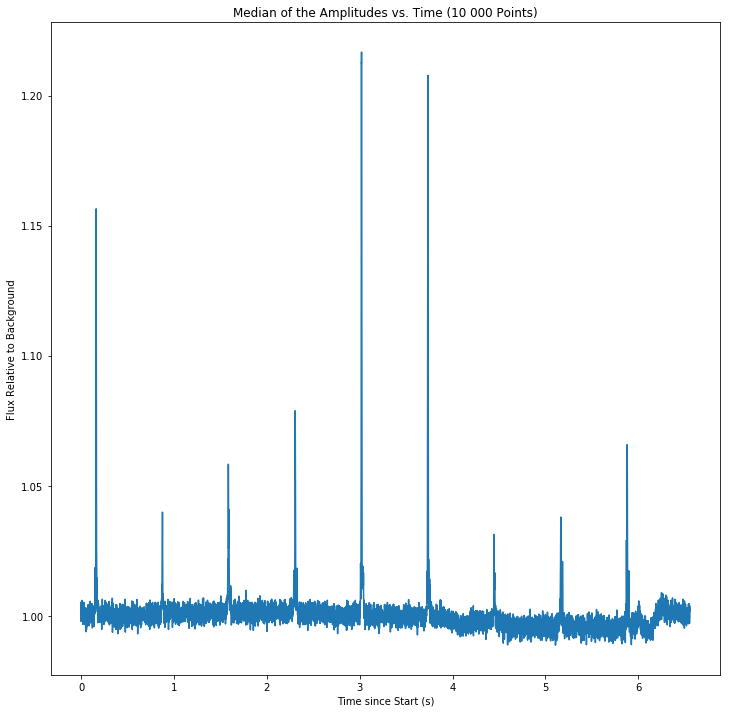

In [20]:
#How pulse amplitudes vary in time
amplitude_data = np.sum(LTE_raw_reshaped, axis=1) #Sum over the frequency axis
normal_amplitude = amplitude_data/np.min(amplitude_data) #Normalize the data
#Calculate the median as well, will result in less noise
amplitude_median = np.median(LTE_raw_reshaped, axis=1)

#Plot the normalized amplitude
plt.figure(figsize=(12,12))
plt.plot(t, normal_amplitude)
plt.title('Amplitude vs. Time (10 000 Points)')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')
plt.savefig('amplitude_time_10000.png')

#Plot the median of the amplitude
plt.figure(figsize=(12,12))
plt.plot(t, amplitude_median) #This plot is less noisy
plt.title('Median of the Amplitudes vs. Time (10 000 Points)')
plt.xlabel('Time since Start (s)')
plt.ylabel('Flux Relative to Background')
plt.savefig('amplitude_median_10000.png')

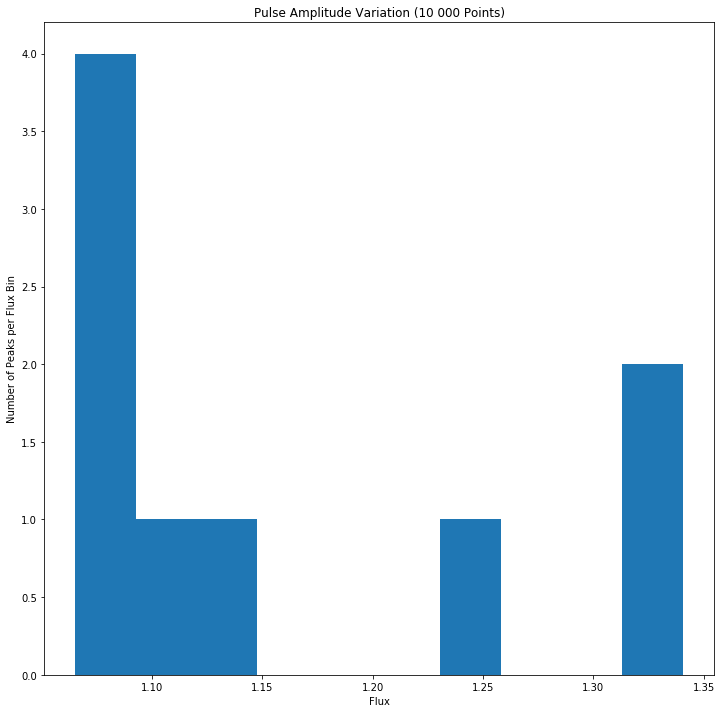

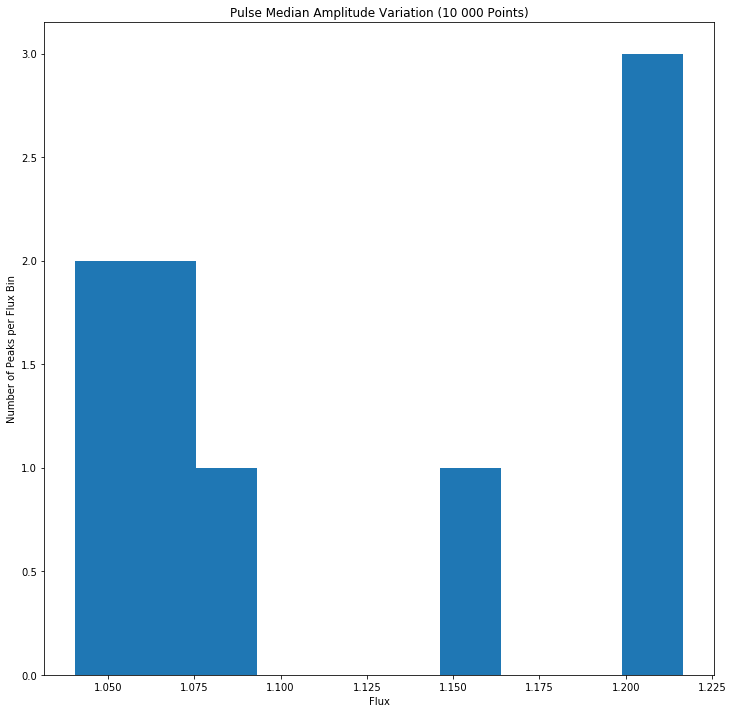

In [21]:
#Find the peaks using Andy's telescope peak finding function:
def centfindert(x, threshold,threshold2): #Choose thresholds
    pixels = np.arange(0,len(x))
    intensity = x
    peaksx = [] #This is the values that the peaks are centred around
    peaksy = []
    peak_dex = (list(intensity))
    inversep_dex=intensity[::-1]
    for i in range(len(intensity)-1):
        if intensity[i] > threshold and intensity[i-1] <intensity[i] and intensity[i+1] < intensity[i]:
            peaksx.append(pixels[i])
            peaksy.append(intensity[i])
    peaksx = np.array(peaksx)
    peaksy = np.array(peaksy)
    return peaksy

#Find the peaks in the amplitude timestream
amplitude_peaks = centfindert(normal_amplitude, 1.0645,1.0645)

#Plot a histogram of the peaks
plt.figure(figsize=(12,12))
plt.hist(amplitude_peaks)
plt.title('Pulse Amplitude Variation (10 000 Points)')
plt.xlabel('Flux')
plt.ylabel('Number of Peaks per Flux Bin')
plt.savefig('amplitude_hist_10000.pdf')

#Find the peaks in the amplitude median plot
amplitude_median_peaks = centfindert(amplitude_median, 1.04, 1.04)

#Plot a histogram of the median peaks
plt.figure(figsize=(12,12))
plt.hist(amplitude_median_peaks)
plt.title('Pulse Median Amplitude Variation (10 000 Points)')
plt.xlabel('Flux')
plt.ylabel('Number of Peaks per Flux Bin')
plt.savefig('amplitude_median_hist_10000.pdf')

In [16]:
#Rebin timeseries data
phase_bins = period/500 #Divide the period by the number of bins in the average pulse profile 
timeseries_bins = phase_bins/timestep #Create bins for the timeseries
print(timeseries_bins)
amplitude_reshaped = normal_amplitude.reshape(-1,2) #Reshape the amplitude data accordingly
amplitude_rebinned = np.mean(amplitude_reshaped, axis=1) #Take the mean

#Pad the average pulse profile with zeros to make it the same length as the timeseries
padded_profile = np.zeros(5000)
for i in range(0,500):
    padded_profile[i] = normal_profile[i]

2.180541075823975


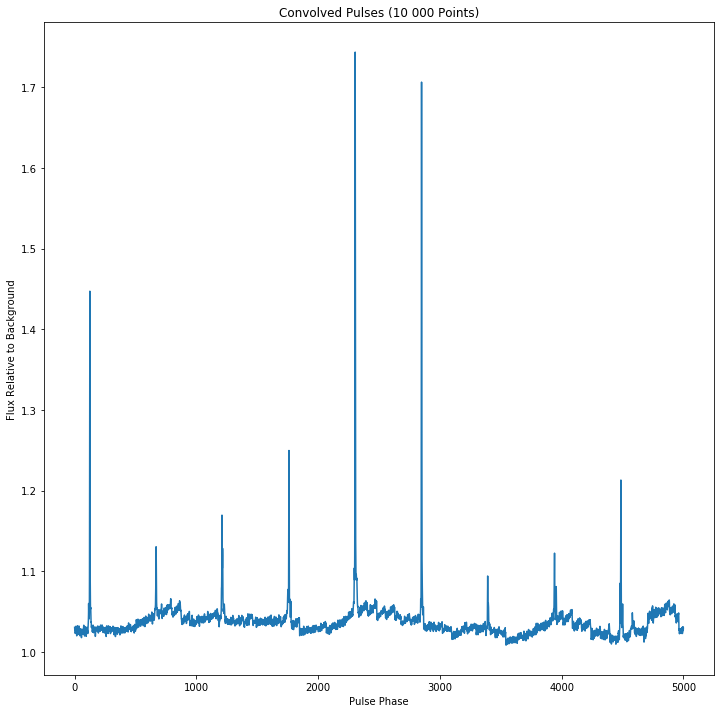

In [22]:
#Convolve the timeseries within the average pulse profile
convolution = np.zeros_like(padded_profile) #Create array of zeros to append convolution data to
for i in range(len(amplitude_rebinned)): #Iterate through length of rebinned amplitude data
    convolution = padded_profile*amplitude_rebinned #Convolve the data 
    padded_profile = np.roll(amplitude_rebinned, 1, axis=0) #Roll the profile through the timestream and convolve with each pulse
    
#Plot the convolution
plt.figure(figsize=(12,12))
plt.plot(convolution)
plt.title('Convolved Pulses (10 000 Points)')
plt.xlabel('Pulse Phase')
plt.ylabel('Flux Relative to Background')
plt.savefig('convolution_10000.pdf')

In [18]:
#Find the peaks in the convolution using Andy's telescope peak finding function: 
convolved_peaks = centfindert(convolution, 1.11,1.11)

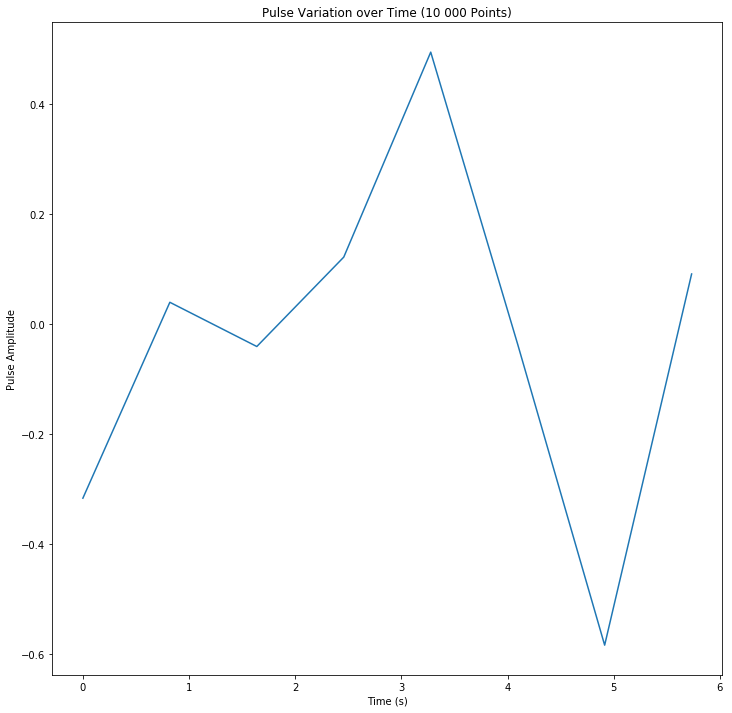

In [23]:
#Take difference between each subsequent pulse to find the variation in the pulses as a function of time
peak_difference = np.zeros(8)
for i in range(len(convolved_peaks)-1):
    peak_difference[i] = convolved_peaks[i + 1] - convolved_peaks[i]

#Plot the pulse variation as a function of time
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t), np.amax(t), (np.amax(t) - np.amin(t))/len(peak_difference)), peak_difference)
plt.title('Pulse Variation over Time (10 000 Points)')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Amplitude')
plt.savefig('pulse_var_10000.pdf')

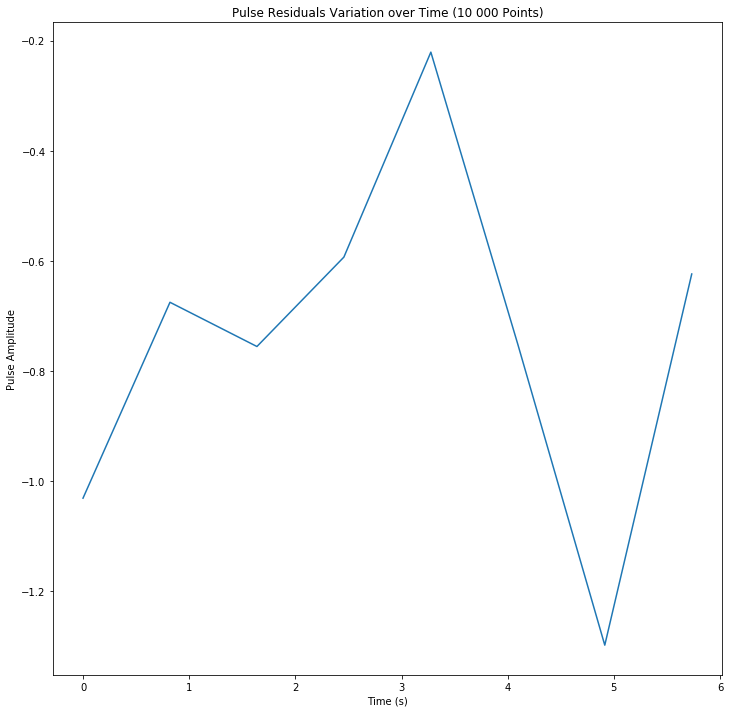

In [24]:
#Calculate the residuals instead, can also see pulse variation here
peak_residuals = peak_difference - period

#Plot the residuals
plt.figure(figsize=(12,12))
plt.plot(np.arange(np.amin(t), np.amax(t), (np.amax(t) - np.amin(t))/len(peak_residuals)), peak_residuals)
plt.title('Pulse Residuals Variation over Time (10 000 Points)')
plt.xlabel('Time (s)')
plt.ylabel('Pulse Amplitude')
plt.savefig('peak_residual_var_10000.pdf')